In [1]:
import numpy as np
from ddeint import ddeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import random
from scipy import stats
import math
import scipy.io

from pymoo.algorithms.soo.nonconvex.pattern_search import PatternSearch
from pymoo.algorithms.soo.nonconvex.sres import SRES
from pymoo.algorithms.soo.nonconvex.pso import PSO

from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_termination

### Standardised ESN helper functions 

In [2]:
# esn helper functions
def gen_matrix(shape, sparsity, sd=1, mean=0, loc_seed=100, val_seed=100, pdf="gaussian", seeded=True):
    
    def seeded_rvs_gauss(array_len):
            return stats.norm(loc=mean, scale=sd).rvs(random_state = val_seed, size=array_len)

    def seeded_rvs_uniform(array_len):
        return stats.uniform(loc=mean, scale=sd).rvs(random_state = val_seed, size=array_len)

    m = shape[0]
    n = shape[1]

    if seeded == True:
        
        if pdf == "gaussian":
            M = random(m, n, density=sparsity, random_state=loc_seed, data_rvs=seeded_rvs_gauss).A
            return M

        if pdf == "uniform":
            M = random(m, n, density=sparsity, random_state=loc_seed, data_rvs=seeded_rvs_uniform).A
            return M

        if pdf == "ones":
            M = random(m, n, density = sparsity, random_state=loc_seed, data_rvs=np.ones).A
            return M
        else: 
            print("No such pdf")
            
    elif seeded == False:
        
        if pdf == "gaussian":
            unseeded_rvs = stats.norm(loc=mean, scale=sd).rvs
            M = random(m, n, density=sparsity, data_rvs=unseeded_rvs).A
            return M

        if pdf == "uniform":
            unseeded_rvs = stats.uniform(loc=mean, scale=sd).rvs
            M = random(m, n, density=sparsity, data_rvs=unseeded_rvs).A
            return M

        if pdf == "ones":
            M = random(m, n, density = sparsity, data_rvs=np.ones).A
            return M
        else: 
            print("No such pdf")
            
    else:
        print("Seeded was neither true nor false")

def spectral_radius(M):
    max_abs_eigenvalue = -1
    eigenvalues, eigenvectors = np.linalg.eig(M)
    for eigenvalue in eigenvalues:
        if abs(eigenvalue) > max_abs_eigenvalue:
            max_abs_eigenvalue = abs(eigenvalue)
    return max_abs_eigenvalue

def spectral_radius_matrix(M, desired_spec_rad):
    M_sr = spectral_radius(M)
    if M_sr == 0:
        return M
    else:
        M = M*(desired_spec_rad/M_sr)
        return M

def sigma(value):
    return np.tanh(value)

# esn - state equation
def state(x_prev, z_curr):
    z_curr = np.atleast_2d(z_curr)
    x_curr = sigma(np.matmul(A, x_prev) + gamma*np.matmul(C, z_curr) + s*zeta)
    return x_curr

# esn - observation equation
def observation(x_curr, w):
    z_next = np.matmul(np.transpose(w), x_curr)
    return z_next

def listening(training_data, x_0, A, gamma, C, s, zeta):
    state_dict = {'all_states': None,
                  'best_weight': None, 
                  'input_data': None}
    
    T = len(training_data)
    
    for t in range(1, T+1):
        if t == 1:
            x_curr = x_0
            X = np.array(x_curr)
            z_curr = training_data.loc[t]['tau17']
            Z = np.atleast_2d(np.array([z_curr]))
        else:
            x_curr = state(x_curr, z_curr)
            X = np.column_stack((X, x_curr))
            z_curr = training_data.loc[t]['tau17']
            Z = np.column_stack((Z, z_curr))
            
    state_dict['last_state'] = x_curr
    state_dict['all_states'] = X
    state_dict['input_data'] = Z
    
    return state_dict
    
def regression_sol(ld, state_dict, N):
    X = state_dict['all_states']
    Z = state_dict['input_data']
    
    X = X[:, 1001:]
    Z = Z[:, 1001:]

    X_transpose = X.transpose()
    Z_transpose = Z.transpose()
    XZ_transpose = np.matmul(X, Z_transpose)
    
    inverse_term = np.linalg.inv(np.matmul(X, X_transpose) + ld*np.identity(N))
    W_best = np.matmul(inverse_term, XZ_transpose)
    
    return W_best

def prediction(state_dict, weight, testing_data, training_data, A, gamma, C, s, zeta, platt_err):
    prediction_dict = {'testing_error': None,
                       'z_actuals': None,
                       'z_predictions': None}
    
    z_actuals = []
    z_predictions = []
    
    last_state = state_dict.get('last_state')
    testing_error = 0
    
    T = len(training_data)
    T_bar = len(testing_data)
    
    weight_sum = 0
    x_prev = last_state
    for t_bar in range(T+1, T+T_bar+1):
        z_predict = observation(x_prev, weight)[0][0]
        x_prev = state(x_prev, z_predict)
        z_predictions.append(z_predict)
        
        z_actual = testing_data.loc[t_bar]['tau17']
        z_actuals.append(z_actual)
        
        if platt_err == True:
            testing_error = testing_error + ((z_predict - z_actual)**2)*np.exp(-((t_bar-T)/T_bar))
            weight_sum = weight_sum + np.exp(-((t_bar-T)/T_bar))
        else:    
            testing_error = testing_error + (z_predict - z_actual)**2
            weight_sum = weight_sum + 1
    
    prediction_dict['testing_error'] = testing_error/weight_sum
    prediction_dict['z_actuals'] = z_actuals
    prediction_dict['z_predictions'] = z_predictions        
        
    return prediction_dict

def training_error(state_dict, weight, training_data):
    training_error_dict = {'training_error': None,
                           'z_actuals': None,
                           'z_predictions': None}
    
    z_actuals = []
    z_predictions = []
    
    X = state_dict.get('all_states')
    
    X = X[:, 1001:]
    
    training_error = 0
    
    T = len(training_data)
    
    for t in range(1001, T):
        x_prev = X[:, t-1001]
        z_predict = observation(x_prev, weight)[0]
        
        z_predictions.append(z_predict)
        z_actual = training_data.loc[t]['tau17']
        z_actuals.append(z_actual)
        training_error = training_error + (z_predict - z_actual)**2
        
    training_error = training_error/(T-1000)
    
    training_error_dict['training_error'] = training_error
    training_error_dict['z_actuals'] = z_actuals
    training_error_dict['z_predictions'] = z_predictions
        
    return training_error_dict

# helper functions to generate data set (Mackey-Glass)
def mantas_data():
    # load data from matlab file mackeyglass time series
    loaded_mat = scipy.io.loadmat('MGTimeseries_dde23_tau17.mat')
    data_tau17 = loaded_mat['MGseries_dde23_tau17'][0]
    data_tau50 = loaded_mat['MGseries_dde23_tau50'][0]

    # clean dataset
    data = pd.DataFrame({'tau17': data_tau17}) # use tau=17 first
    data.index = data.index + 1

    # split data set
    training_data = data.loc[1:3001]
    testing_data = data.loc[3002:]
    
    return training_data, testing_data

def generate_MG_data(init_val, tau, a, b, n):
    def MackeyGlass(z, t):
        return (a * z(t - tau)) / (1 + z(t - tau)**n) - b*z(t)

    def initial(t):
        return init_val

    time_space = np.arange(0, 5000, 1)

    z_solution_new = ddeint(MackeyGlass, initial, time_space)
    z_solution_new  = [ data_pt[0] for data_pt in z_solution_new[1:] ]
    z_solution_new.insert(0, init_val)
    z_solution_new = [ np.tanh(unshifted_val-1) for unshifted_val in z_solution_new ]
    z_sol_new_df = pd.DataFrame(z_solution_new, columns=['tau17'])

    z_sol_new_df.index = z_sol_new_df.index + 1
    training_data = z_sol_new_df.loc[1:3001]
    testing_data = z_sol_new_df.loc[3002:]
    
    return training_data, testing_data


def state_plot(state_dict, plotwith_init, node=0):
    X = state_dict.get('all_states')
    if plotwith_init == True:
        state_plot, state_ax = plt.subplots(figsize=(20,5))
        state_ax.plot(X[node][:])
        state_ax.set_title('Plot of States at node {}'.format(node))
        state_ax.set_xlabel('time')
        state_ax.set_ylabel('state of node {}'.format(node))
        
        return (np.amin(X[node][:]), np.amax(X[node][:]))
    
    if plotwith_init == False:
        state_plot, state_ax = plt.subplots(figsize=(20,5))
        state_ax.plot(X[node][1001:])
        state_ax.set_title('Plot of States at node {}'.format(node))
        state_ax.set_xlabel('time')
        state_ax.set_ylabel('state of node {}'.format(node))
    
        return (np.amin(X[node][1001:]), np.amax(X[node][1001:]))
                
def hist_accuracy_plot(actuals, predictions, with_bars=False):
    if with_bars == False:
        sns.kdeplot(actuals, label='actual', shade=True, color='red')
        sns.kdeplot(predictions, label='prediction', shade=True, color='skyblue')
        plt.legend()
        
    if with_bars == True:
        sns.histplot(actuals, label='actual', color='red', kde=True)
        sns.histplot(predictions, label='prediction', color='skyblue', kde=True)
        plt.legend()

### Data generation

In [15]:
data = mantas_data()
training_data = data[0]
testing_data = data[1]

In [3]:
data = generate_MG_data(1.2, 17, 0.2, 0.1, 10)
training_data = data[0]
testing_data = data[1]

/Users/hannah/Library/Python/3.8/lib/python/site-packages/ddeint/ddeint.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([g(tt[0])] + results)


### Tuned echo state network

Training error:  0.0010982053123957918
Testing error:  0.07097682318830786


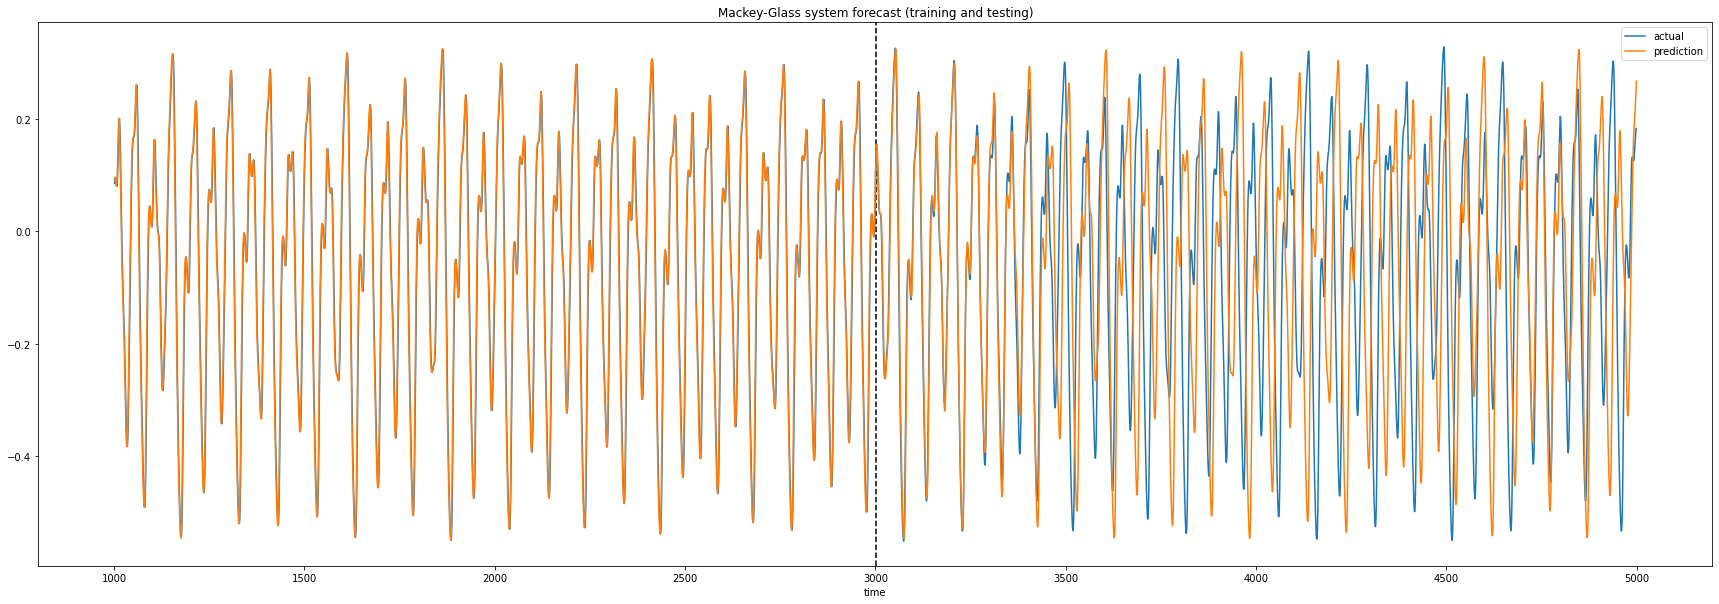

In [4]:
N = 1000
ld = 10**(-14)
C = gen_matrix(shape=(N,1), sparsity=0.6, sd=4, mean=-2, pdf="uniform", seeded=True, loc_seed=407, val_seed=408)
gamma = 0.8
A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, pdf="uniform", seeded=True, loc_seed=500, val_seed=508)
spec_rad = 1.2
A = spectral_radius_matrix(A, spec_rad)
s = 0.2
zeta = gen_matrix(shape=(N,1), sparsity=0.6, pdf="ones", loc_seed=400, seeded=True)
x_0 = np.zeros(shape=(N,1), dtype=float)

state_dict = listening(training_data, x_0, A, gamma, C, s, zeta)
weight_result = regression_sol(ld, state_dict, N) 

training = training_error(state_dict, weight_result, training_data)
predicting = prediction(state_dict, weight_result, testing_data, training_data, A, gamma, C, s, zeta, True)

print("Training error: ", training['training_error'])
print("Testing error: ", predicting['testing_error'])

z_actuals = training['z_actuals'] + predicting['z_actuals']
z_predictions = training['z_predictions'] + predicting['z_predictions']

forecast_plot, forecast_ax = plt.subplots(figsize=(30, 10))
forecast_ax.axvline(len(training_data), color='black', linestyle="--")
forecast_ax.plot(range(1001, len(z_actuals)+1001), z_actuals, label='actual')
forecast_ax.plot(range(1001, len(z_predictions)+1001), z_predictions, label='prediction')
forecast_ax.set_title('Mackey-Glass system forecast (training and testing)')
forecast_ax.set_xlabel('time')
forecast_ax.legend()

### Tuning using Pymoo code

In [5]:
class ESNError(ElementwiseProblem):
    
    def __init__(self):
        super().__init__(n_var=6,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([0, 0, 0, 0, 0, 1]),
                         xu=np.array([1, 2, 2, 1, 1, 20]))
        
    def _evaluate(self, params, out, *args, **kwargs):
        N = 1000
        ld = 10**(-1*params[5])
        C = gen_matrix(shape=(N,1), sparsity=params[0], sd=4, mean=-2, pdf="uniform", seeded=True, loc_seed=407, val_seed=408)
        gamma = params[1]
        A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, pdf="uniform", seeded=True, loc_seed=500, val_seed=508)
        spec_rad = params[2]
        A = spectral_radius_matrix(A, spec_rad)
        s = params[3]
        zeta = gen_matrix(shape=(N,1), sparsity=params[4], pdf="ones", loc_seed=400, seeded=True)
        x_0 = np.zeros(shape=(N,1), dtype=float)

        state_dict = listening(training_data, x_0, A, gamma, C, s, zeta)
        weight_result = regression_sol(ld, state_dict, N) 
        
        predicting = prediction(state_dict, weight_result, testing_data, training_data, A, gamma, C, s, zeta, True)
        
        out['F'] = predicting['testing_error']

In [6]:
problem = ESNError()

In [9]:
initial_points = np.array([0.6, 0.8, 1.2, 0.2, 0.6, 14])
pattern_search = PatternSearch(x0=initial_points)
res_ps = minimize(problem, pattern_search, get_termination("time", "00:07:00"))

print()
print("Positions are: ", res_ps.X)
print("Have an error of: ", res_ps.F)


Positions are:  [ 0.6      0.8      1.2      0.2      0.6     13.40625]
Have an error of:  [0.06943113]


In [ ]:
pso = PSO()
res_pso = minimize(problem, pso, get_termination("time", "00:10:00"), pop_size=30, verbose=True, seed=600)

print()
print("Positions are: ", res_pso.X)
print("Have an error of: ", res_pso.F)

### Check and hand tuning

Training error:  0.0010982061322562149
Testing error:  0.06943113370344228


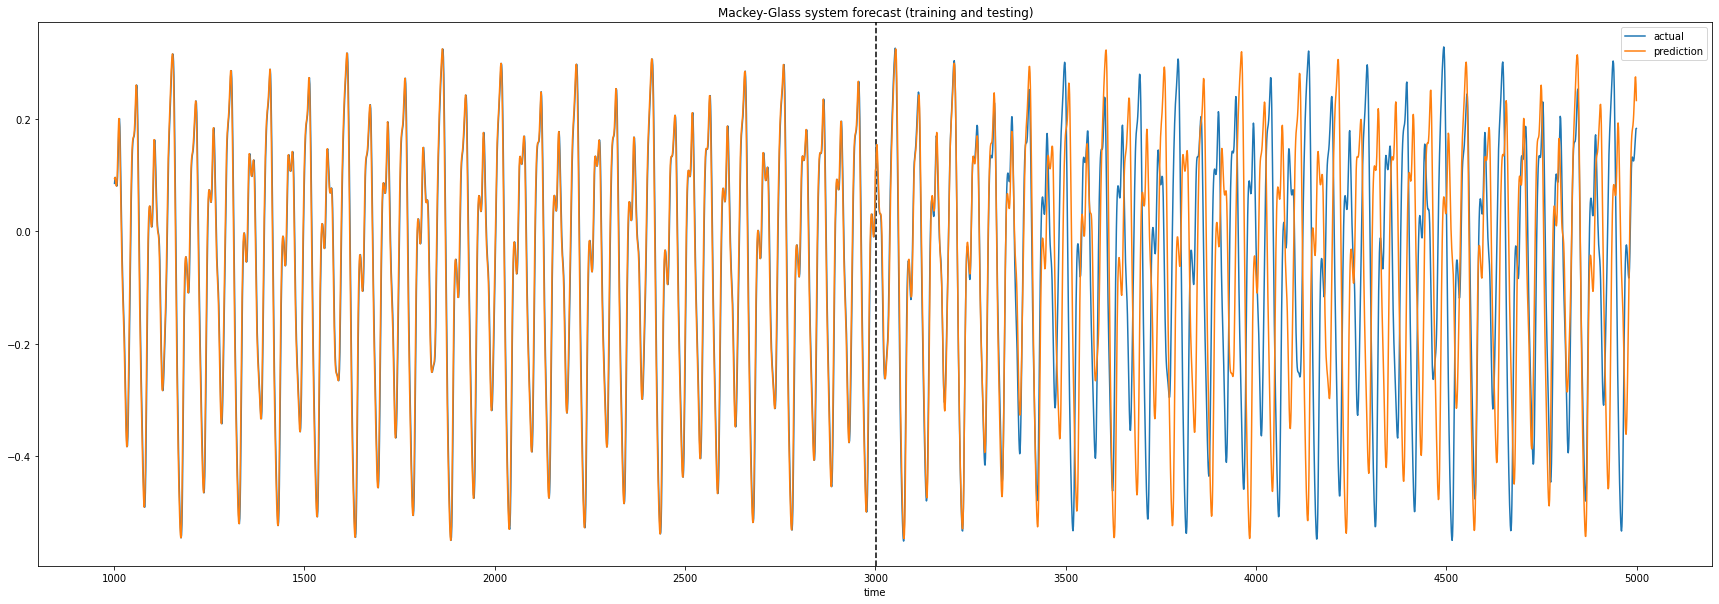

In [8]:
N = 1000
ld = 10**(-13.40625)
C = gen_matrix(shape=(N,1), sparsity=0.6, sd=4, mean=-2, pdf="uniform", seeded=True, loc_seed=407, val_seed=408)
gamma = 0.8
A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, pdf="uniform", seeded=True, loc_seed=500, val_seed=508)
spec_rad = 1.2
A = spectral_radius_matrix(A, spec_rad)
s = 0.2
zeta = gen_matrix(shape=(N,1), sparsity=0.6, pdf="ones", loc_seed=400, seeded=True)
x_0 = np.zeros(shape=(N,1), dtype=float)

state_dict = listening(training_data, x_0, A, gamma, C, s, zeta)
weight_result = regression_sol(ld, state_dict, N) 

training = training_error(state_dict, weight_result, training_data)
predicting = prediction(state_dict, weight_result, testing_data, training_data, A, gamma, C, s, zeta, True)

print("Training error: ", training['training_error'])
print("Testing error: ", predicting['testing_error'])

z_actuals = training['z_actuals'] + predicting['z_actuals']
z_predictions = training['z_predictions'] + predicting['z_predictions']

forecast_plot, forecast_ax = plt.subplots(figsize=(30, 10))
forecast_ax.axvline(len(training_data), color='black', linestyle="--")
forecast_ax.plot(range(1001, len(z_actuals)+1001), z_actuals, label='actual')
forecast_ax.plot(range(1001, len(z_predictions)+1001), z_predictions, label='prediction')
forecast_ax.set_title('Mackey-Glass system forecast (training and testing)')
forecast_ax.set_xlabel('time')
forecast_ax.legend()